In [ ]:
####################

# Final Project, GAN

####################


import numpy as np
import pickle
import os
import soundfile as sf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


# set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# to load or dataset from the file

def load_dataset(dataset_name):
    dataset_path = '/content/drive/MyDrive/' + dataset_name
    with open(dataset_path, 'rb') as f_dataset:
        dataset = pickle.load(f_dataset)
    print(dataset.shape)
    return dataset

# to produce a wav file from a numpy array

def produce_wav(wav_data, file_name, sample_rate=8000):
    if not os.path.isdir('./generated_wav/'):
        os.mkdir('./generated_wav/')
    wav_dir = './generated_wav/' + file_name
    sf.write(wav_dir, wav_data, sample_rate, 'PCM_24')


# convolutional discriminator
# currently designed for inputs of size (1, 1600)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    # padding is added to maintain proper dimensions after convolution
    self.conv1 = nn.Conv2d(1, 5, (1, 20), (1, 5))
    self.conv2 = nn.Conv2d(5, 20, (1, 5), (1, 4))
    self.conv3 = nn.Conv2d(20, 25, (1, 5), 1)

    # linear layers reduce to 1 output
    self.linear1 = nn.Linear(275, 15)
    self.linear2 = nn.Linear(15, 1)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    x = x.view(-1, 1, 1, 1600).to(device)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, (1, 3), (1, 2))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, (1, 3), (1, 1))
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, (1, 3), 3)
    x = x.view(-1, 1, 275)
    x = F.relu(self.linear1(x))
    x = self.sig(self.linear2(x))

    return x.view(-1, 1)



# Generator
# designed for input of (1, 200)

class Generator(nn.Module):
  def __init__(self, input_dim, output_dim, num_labels=10):
    super(Generator,self).__init__()

    # self.linear1 = nn.Linear(200, 800)
    # self.linear2 = nn.Linear(800, 2000)

    # self.conv1 = nn.Conv2d(10, 4, (1, 21), 1, padding=(0, 10))
    # self.conv2 = nn.Conv2d(4, 1, (1, 201), 1, padding=(0, 100))
    # self.conv3 = nn.Conv2d(1, 1, (1, 1001), 1, padding=(0, 500))

    # self.linear1 = nn.Linear(16000, 16000)
    # self.linear2 = nn.Linear(16000, 16000)

    # expand width as high as 8000
    self.linear1 = nn.Linear(200, 1000)
    self.linear2 = nn.Linear(1000, 8000)
    self.linear3 = nn.Linear(8000, 4000)
    self.linear4 = nn.Linear(4000, 1600)

    self.nonlin1 = nn.Tanh()
    self.nonlin2 = nn.Tanh()
    self.nonlin3 = nn.Tanh()

    # self.upsample1 = nn.Upsample(scale_factor=(1, 10), mode='nearest')
    # self.upsample2 = nn.Upsample(scale_factor=(1, 8), mode='nearest')

  def forward(self, x):
    x = F.leaky_relu(self.linear1(x))
    x = self.nonlin1(x)
    x = F.leaky_relu(self.linear2(x))
    x = self.nonlin2(x)
    x = F.leaky_relu(self.linear3(x))
    x = self.nonlin3(x)
    x = self.linear4(x)

    return x




In [ ]:
0from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# test of sending data through generator and discriminator

array = np.ones((1, 200))
test = torch.FloatTensor(array).resize(1, 1, 1, 200)

gen = Generator((1, 200), (1, 1600))
gen.eval()

generation = gen(test)
print(generation.size())

disc = Discriminator().to(device)
disc.eval()

print(disc(generation).size())

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


torch.Size([1, 1, 1, 1600])
torch.Size([1, 1])


In [ ]:

# set learning rates, initialize models, define network training functions

# tried many learning rates; any small one seems to work, but they seem to work best if they are similar to eachother 
disc_learning_rate = 0.001
gen_learning_rate = 0.001

discriminator = Discriminator().to(device)
generator = Generator((1,200), (1, 1600)).to(device)

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=disc_learning_rate)
generator_optimizer = optim.Adam(generator.parameters(), lr=gen_learning_rate)

loss_function = nn.BCELoss()


def train_generator(batch_size):
    """
    Performs a training step on the generator by
        1. Generating fake song clips from random noise.
        2. Running the discriminator on the fake clips.
        3. Computing loss on the result.
    :arg batch_size: the number of training examples in the current batch
    Returns the average generator loss over the batch.
    """
    # zero gradients, prep noise
    generator_optimizer.zero_grad()
    noise = torch.randn(batch_size, 1, 1, 200).to(device)

    # run through generator and discriminator
    generations = generator(noise)
    decisions = discriminator(generations)

    # find loss, backpropogate, and step optimizer
    loss = torch.sum(-torch.log(decisions)) / batch_size
    loss.backward()
    generator_optimizer.step()

    return loss

def train_discriminator(batch_size, clips):
    """
    Performs a training step on the discriminator by
        1. Generating fake song clip from random noise.
        2. Running the discriminator on the fake clips.
        3. Running the discriminator on the real clips
        3. Computing loss on the results.
    :arg batch_size: the number of training examples in the current batch
    :arg clips: the current batch of clips, a tensor of size BATCH x 1 x 1 x 1600
    Returns the average loss over the batch.
    """

    # zero gradients, prep noise
    discriminator_optimizer.zero_grad()
    noise = torch.randn(batch_size, 1, 1, 200).to(device)

    # run through generator and discriminator
    generations = generator(noise)
    fake_results = discriminator(generations)
    real_results = discriminator(clips).to(device)

    # find loss, backpropogate, and step optimizer
    loss = loss_function(real_results, torch.ones(batch_size, 1).to(device)) / batch_size
    loss += loss_function(fake_results, torch.zeros(batch_size, 1).to(device)) / batch_size
    loss.backward()
    discriminator_optimizer.step()

    return loss


In [ ]:
# create train_loader using clip data

#set batch size
batch_size = 50


# load clip data
data = load_dataset('dataset_wav_10000.pkl')
data = torch.FloatTensor(data).resize(10000, 1, 16000)

# shorten to use first 1600 samples of each clip
data = data[:, :, :1600]

clip_dataset = torch.utils.data.TensorDataset(data, data)

train_loader = torch.utils.data.DataLoader(
    clip_dataset,
    batch_size = batch_size,
    shuffle=True
    )


(10000, 16000)


In [ ]:

# set epochs
epochs = 15

# training loop
for epoch in range(epochs):
  G_loss = []
  D_loss = []

  for batch, (clips, targets) in enumerate(train_loader):
    batch_size = clips.shape[0]
    lossG = train_generator(batch_size)
    # lossG = train_generator(batch_size)
    # lossG = train_generator(batch_size)
    G_loss.append(lossG)
    lossD = train_discriminator(batch_size, clips)
    lossD = train_discriminator(batch_size, clips)
    D_loss.append(lossD)

    # print the loss every epoch
    if ((batch + 1) % 200 == 0 and (epoch + 1) % 1 == 0):
      print("Training Steps Completed: ", batch)
      print(f"Epoch {epoch}: loss_d: {torch.mean(torch.FloatTensor(D_loss))}, loss_g: {torch.mean(torch.FloatTensor(G_loss))}")

In [ ]:
# test a single generation

generator.eval()

random_noise = torch.randn(1, 1, 200).to(device)
sample = generator(random_noise).detach().to('cpu').resize(1600)

produce_wav(sample, 'sample.wav')

In [ ]:
print(data[0])
print(sample)

tensor([[-0.0956, -0.0914, -0.0543,  ...,  0.4285,  0.3489,  0.2730]])
tensor([-0.9157,  0.7859, -0.6776,  ..., -0.0039, -0.0125,  0.0250])


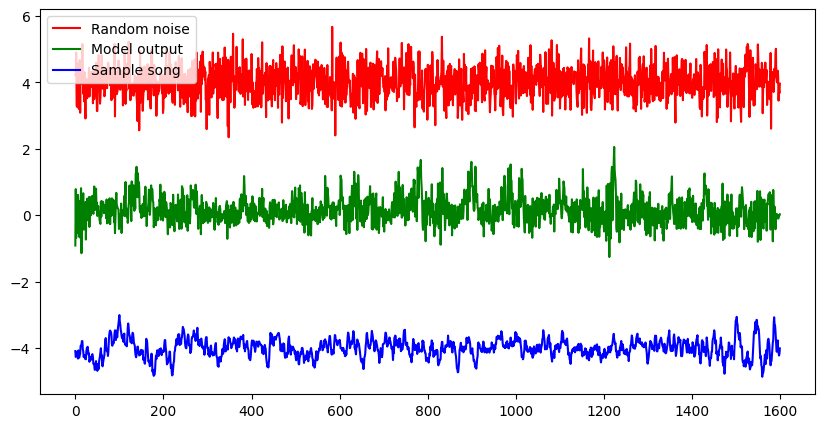

In [ ]:
# to plot a waveform, sample count on x axis

fig = plt.figure(figsize = (10,5))

plt.plot(np.arange(0, 1600), torch.randn(1600) / 2 + 4, color='r')
plt.plot(np.arange(0, 1600), sample, color='g')
plt.plot(np.arange(0, 1600), data[40][0] - 4, color='b')

plt.legend(['Random noise', 'Model output', 'Sample song'])

plt.show()

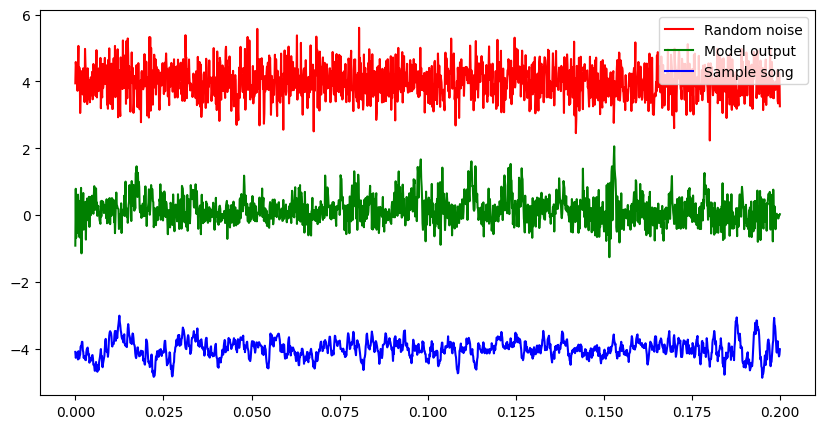

In [ ]:
# to plot a waveform, seconds on x axis

fig = plt.figure(figsize = (10,5))

plt.plot(np.arange(0, 0.2, 0.000125), torch.randn(1600) / 2 + 4, color='r')
plt.plot(np.arange(0, 0.2, 0.000125), sample, color='g')
plt.plot(np.arange(0, 0.2, 0.000125), data[40][0] - 4, color='b')

plt.legend(['Random noise', 'Model output', 'Sample song'])

plt.show()